## Optimising Dream 11 Team Selection ##

### Section 1.1 Data Preparation :
1) Prepare a Score Vector (The mean of a Player's Score across 10 Matches is considered) <br>
2) Prepare Standard Deviation Vector( to capture variability or inconsistencies in player's scores). This is to be used in Mean Variance Optimisation

In [1]:
 !pip install gurobipy

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/10.2 MB ? eta -:--:--
                                              0.0/10.2 MB ? eta -:--:--
                                             0.0/10.2 MB 653.6 kB/s eta 0:00:16
                                             0.1/10.2 MB 469.7 kB/s eta 0:00:22
                                             0.1/10.2 MB 819.2 kB/s eta 0:00:13
                                             0.1/10.2 MB 819.2 kB/s eta 0:00:13
                                             0.1/10.2 MB 514.3 kB/s eta 0:00:20
                                             0.2/10.2 MB 860.2 kB/s eta 0:00:12
                                             0.2/10.2 MB 860.2 kB/s eta 0:00:12
                                             0.2/10.2 MB 684.7 kB/s eta 0:00:15
                                             0.2/10.2 MB 684.7 kB/s eta 0:00:15
     -                                       0.3/10.2 MB 7

In [4]:
import pandas as pd
import numpy as np
from gurobipy import *
#str = unicode(str, errors='ignore')
data_set_df=pd.read_csv(r'Players_Score_Names.csv', encoding='gbk')
data_set_df.head()

,Player Name,Player Type,Team,Retrospective Scores_10,Retrospective Scores_1,Retrospective Scores_2,Retrospective Scores_3,Retrospective Scores_4,Retrospective Scores_5,Retrospective Scores_6,Retrospective Scores_7,Retrospective Scores_8,Retrospective Scores_9,Price
0,Virat Kohli,BAT,INDIA,145,128,41,55,85,56,3,122,4,54,17
1,Rohit Sharma,BAT,INDIA,46,48,86,131,0,81,6,53,56,74,15
2,Shubman Gill,BAT,INDIA,26,53,16,104,74,27,121,19,58,67,8
3,Shreyas Iyer,BAT,INDIA,33,19,53,25,0,48,105,3,14,38,12
4,Surya Kumar Yadav,BAT,INDIA,2,8,72,50,26,35,24,19,0,0,12


#### Find mean and Standard Deviation of the scores of all 30 Players ###

In [5]:
score_df=data_set_df.iloc[0:,3:data_set_df.shape[1]-1] # Separate the score data from other details

In [6]:
sd_score=[np.std(score_df.iloc[i,:].values) for i in range(score_df.shape[0])] #Standard Deviation to measure inconsistency
scores=[np.mean(score_df.iloc[i,:].values) for i in range(score_df.shape[0])] #Score of each player

In [7]:
#########Other Parameters Set-up############

# Intialise a Player Type(Batsman,Bowler,Allrounder or Wicket Keeper) Matrix
ptype=np.zeros((4,30))

# Initialize a Team Matrix (The Dream 11 Team has to be formed from two competing Teams)
team=np.zeros((2,30))

# Fill in the Player and Team matrices with values from Dataset
for i in range(data_set_df.shape[0]):
    if(data_set_df.loc[i,'Player Type']=='BAT'):
        ptype[0,i]=1
    elif(data_set_df.loc[i,'Player Type']=='BOWL'):
        ptype[1,i]=1
    elif(data_set_df.loc[i,'Player Type']=='AR'):
        ptype[2,i]=1
    else:
        ptype[3,i]=1
    if(data_set_df.loc[i,'Team']=='INDIA'):
        team[0,i]=1
    else:
        team[1,i]=1

# Prepare a Budget Vector
price=data_set_df['Price'].values

# Prepare the lower bound and upper bound for Player Type . This is to be read as :
# The no. of batsman can be between 3 and 6 (lb[0] and ub[0] respectively)
# Similarly, the no. of bowlers can be between 3 and 6; No. of allrounders can be between 1 and 4; 
# and No of wicketkeeper can be between 1 and 4
lb=[3,3,1,1]
ub=[6,6,4,4]

# There can only be 1 Captain, 1 Vice Captain and the rest 9 players will be considered as normal players
player_role=[9,1,1]


N=data_set_df.shape[0] # No of Players available 
M=len(player_role) #No of Player Roles (N,VC,C)
K=ptype.shape[0] #No. of Player Types (4-BAT,BOWL,AR,WK)

# Risk_aversion captures the risk tolerance of a Dream 11 Player. 
#From a problem perspective, we aim to punish a player for his inconsistency. Risk_aversion captures the degree of punishment

# risk_aversion=0

### Section 1.2 Stating the Objective Function and Constraints. Displaying the Output ###

In [8]:
def dream11_optimisation():
    data_set = Model()

    # Creat variables
    x=data_set.addVars(M, N, vtype=GRB.BINARY, name = "x")

    # Set objective : A Vice Captain has his score multiplied by 1.5 and A captain has his score multiplied by 2.
    # Additionally, a Player is punished for his inconsistency (A form of Mean Variance Optimisation, 
    # used mostly in financial portfolio management)
    data_set.setObjective( w*quicksum(scores[j]*x[0,j] for j in range(N))\
                  +w*quicksum(1.5*scores[j]*x[1,j] for j in range(N))\
                  +w*quicksum(2*scores[j]*x[2,j] for j in range(N))\
                  -(1-w)*risk_aversion*(quicksum(x[i,j]*sd_score[j] for i in range(M) for j in range(N))), GRB.MAXIMIZE)
    
    # The Player can either not be selected and if selected, can only take in one of the role : Either a Captain, Vice Captain or
    # an ordinary player
    data_set.addConstrs(( quicksum(x[i,j] for i in range(M)) <= 1 for j in range(N) )) ##equation 3
    
    # The below constraint ensures that there are 9 ordinary players, only 1 Vice Captain and only 1 Captain in the Team
    data_set.addConstrs(quicksum(x[i,j] for j in range(N)) ==player_role[i] for i in range(M))
    
    # Only 100 Points are available for Spending
    data_set.addConstr(quicksum(price[j]*x[i,j] for i in range(M) for j in range(N)) <=100) ##equation2
    
    # The no of Batsman,Bowler, Allrounder and WK has to be within the specified ranges
    data_set.addConstrs(quicksum(x[i,j]*ptype[k,j] for i in range(M) for j in range(N))<=ub[k] for k in range(K)) ##equation 6

    data_set.addConstrs(quicksum(x[i,j]*ptype[k,j] for i in range(M) for j in range(N))>=lb[k] for k in range(K)) ##equation 6

    # There can be a maximum of 7 players from one team
    data_set.addConstrs(quicksum(x[i,j]*team[k,j] for i in range(M) for j in range(N))<=7 for k in range(team.shape[0])) ##equation 5

    return data_set,x

In [9]:
# risk_aversion can vary between 1 to 10: 
# A risk_aversion score of 0 means the risk taking apetite is huge. This Dream 11 Player doesn't take inconsistencies in 
# data_setket players performance into account while selecting his Playing 11. 
# 10 signifies that the risk-taking apetite of the Dream 11 player is almost negligible. He/She would prefer only consistent
# players in his/her playing 11   
while (True):
    risk_aversion = int(input("Enter your risk tolerance : "))
    if(risk_aversion>10 or risk_aversion < 0 ):
        print("Invalid Input!!. Please Choose a tolerance limit between 0 and 10"+"(both inclusive)")
        continue
    else:
        print ('Risk Tolerance of the Dream-11 Player is',risk_aversion)
        break

solution_list = []
f1_list = []
f2_list = []
    
w_list = np.linspace(0.001,0.9999,30)
for w in w_list:
    # setup the model again
    dr_data_set,x = dream11_optimisation()

    #Supressing the optimization output
    dr_data_set.setParam('OutputFlag', False )

    # Solving the model
    dr_data_set.optimize()
    
    # store optimal solution
    solution_list.append(dr_data_set)
    
    # calculate objectives
    x0 = []
    for v in dr_data_set.getVars()[0:30]:
        x0.append(v.x)
        
    x1 = []
    for v in dr_data_set.getVars()[30:60]:
        x1.append(v.x)
        
    x2 = []
    for v in dr_data_set.getVars()[60:90]:
        x2.append(v.x)
   
    x = np.vstack((x0,x1,x2))
    
    f1 = quicksum(scores[j]*x[0,j] for j in range(N))\
                  +quicksum(1.5*scores[j]*x[1,j] for j in range(N))\
                  +quicksum(2*scores[j]*x[2,j] for j in range(N))
    f2 = risk_aversion*(quicksum(x[i,j]*sd_score[j] for i in range(M) for j in range(N)))
    
    # store objectives 
    f1_list.append(f1.getValue()) 
    f2_list.append(f2.getValue()) 
    

Enter your risk tolerance : 3
Risk Tolerance of the Dream-11 Player is 3
Restricted license - for non-production use only - expires 2025-11-24


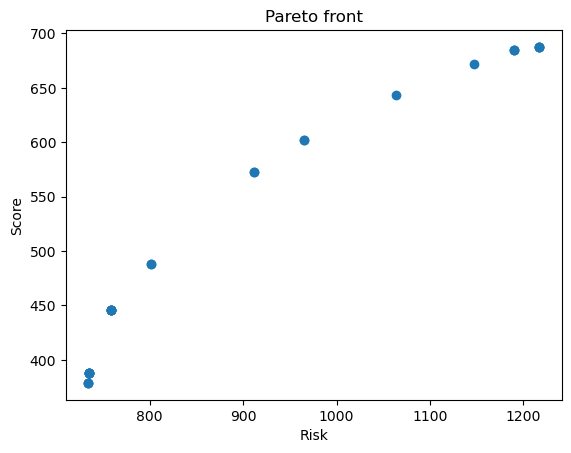

In [10]:
# plot pareto front
import matplotlib.pyplot as plt
# Plot the data
plt.scatter(f2_list, f1_list)

plt.title("Pareto front")
plt.xlabel("Risk")
plt.ylabel("Score")

# Show the plot
plt.show()

In [11]:
pd.DataFrame({'w1': w_list, 'w2': 1-w_list, 'f1':f1_list, 'f2':f2_list})

,w1,w2,f1,f2
0,0.001000,0.999000,378.75,734.363382
1,0.035445,0.964555,378.75,734.363382
2,0.069890,0.930110,378.75,734.363382
3,0.104334,0.895666,387.45,735.286085
4,0.138779,0.861221,387.45,735.286085
5,0.173224,0.826776,387.45,735.286085
6,0.207669,0.792331,387.45,735.286085
7,0.242114,0.757886,387.45,735.286085
8,0.276559,0.723441,387.45,735.286085
9,0.311003,0.688997,445.95,758.959035


In [12]:
# Display the Output for solution_no

while (True):
    sol_no = int(input("Enter solution number to see the team : "))
    if(sol_no>10 or sol_no < 0 ):
        print("Invalid Input!!. Please Choose a solution number between 0 and 9"+"(both inclusive)")
        continue
    else:
        print ('Solution number chosen is',sol_no)
        break

dr_data_set = solution_list[sol_no]
vars = dr_data_set.getVars()

print('\nThe Optimum Team for the upcoming match based on your risk tolerance and solution number is shown below:- \n')
for v in vars:
    if(int(v.VarName[2])==2 and v.x > 0):
        index=int(v.VarName[v.VarName.index(',')+1:v.VarName.index(']')])
        print('The Captain of the Team is',data_set_df.loc[index,'Player Name'] + \
          '('+ data_set_df.loc[index,'Player Type'] +')'+ ' from '+ data_set_df.loc[index,'Team'])
for v in vars:
    if(int(v.VarName[2])==1 and v.x > 0):
        index=int(v.VarName[v.VarName.index(',')+1:v.VarName.index(']')])
        print('The Vice Captain of the Team is',data_set_df.loc[index,'Player Name'] + \
              '('+ data_set_df.loc[index,'Player Type'] +')'+ ' from '+ data_set_df.loc[index,'Team']+'\n')
print('Other Players:- \n')
for v in vars:
    if(int(v.VarName[2])==0 and v.x > 0):
        index=int(v.VarName[v.VarName.index(',')+1:v.VarName.index(']')])
        print(data_set_df.loc[index,'Player Name'] +'('+ data_set_df.loc[index,'Player Type'] +')'+ \
              ' from '+ data_set_df.loc[index,'Team'])

Enter solution number to see the team : 1
Solution number chosen is 1

The Optimum Team for the upcoming match based on your risk tolerance and solution number is shown below:- 

The Captain of the Team is Jasprit Bumrah(BOWL) from INDIA
The Vice Captain of the Team is Sam Curran(AR) from ENGLAND

Other Players:- 

Shreyas Iyer (BAT) from INDIA
Surya Kumar Yadav(BAT) from INDIA
R Ashwin(BOWL) from INDIA
JB Bairstow(WKT) from ENGLAND
Harry Brook(BAT) from ENGLAND
Jos Buttler(WKT) from ENGLAND
Moeen Ali(AR) from ENGLAND
Gus Attkinson(BOWL) from ENGLAND
Mark Wood(BOWL) from ENGLAND
